<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W4/ungraded_labs/C4_W4_Lab_1_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [38]:
#!pip install tensorflow==2.5.0

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2.7.0


In [40]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

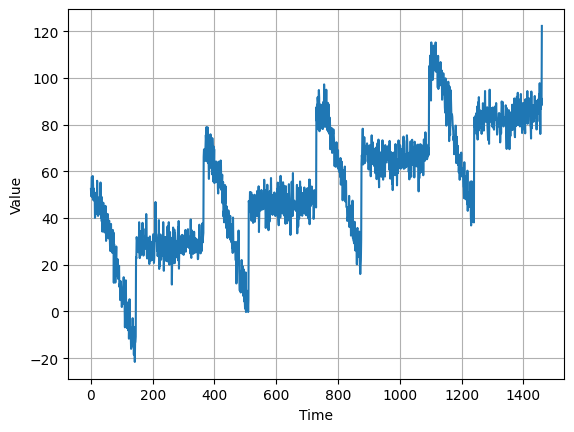

In [3]:

plot_series(time, series)
plt.show()

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [5]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], validation_data=valid_set)

Epoch 1/100
8/8 [==============================] - 10s 331ms/step - loss: 108.0161 - mae: 108.5160 - val_loss: 85.8492 - val_mae: 86.3491 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 106.9664 - mae: 107.4663 - val_loss: 84.3297 - val_mae: 84.8297 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 28ms/step - loss: 105.2832 - mae: 105.7831 - val_loss: 82.2990 - val_mae: 82.7989 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 31ms/step - loss: 103.1634 - mae: 103.6633 - val_loss: 79.8778 - val_mae: 80.3777 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 100.6810 - mae: 101.1810 - val_loss: 77.0880 - val_mae: 77.5879 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 26ms/step - loss: 97.8390 - mae: 98.3389 - val_loss: 73.9458 - val_mae: 74.4457 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 27ms/step - loss: 94.6391 - 

8/8 [==============================] - 0s 29ms/step - loss: 6.1516 - mae: 6.6309 - val_loss: 7.3715 - val_mae: 7.8546 - lr: 5.0119e-06
Epoch 56/100
8/8 [==============================] - 0s 27ms/step - loss: 6.0121 - mae: 6.4909 - val_loss: 7.3229 - val_mae: 7.8046 - lr: 5.6234e-06
Epoch 57/100
8/8 [==============================] - 0s 27ms/step - loss: 5.8549 - mae: 6.3342 - val_loss: 7.1059 - val_mae: 7.5870 - lr: 6.3096e-06
Epoch 58/100
8/8 [==============================] - 0s 27ms/step - loss: 5.7118 - mae: 6.1914 - val_loss: 6.7829 - val_mae: 7.2640 - lr: 7.0795e-06
Epoch 59/100
8/8 [==============================] - 0s 28ms/step - loss: 5.5427 - mae: 6.0210 - val_loss: 6.7361 - val_mae: 7.2157 - lr: 7.9433e-06
Epoch 60/100
8/8 [==============================] - 0s 26ms/step - loss: 5.4047 - mae: 5.8832 - val_loss: 6.4011 - val_mae: 6.8819 - lr: 8.9125e-06
Epoch 61/100
8/8 [==============================] - 0s 26ms/step - loss: 5.2546 - mae: 5.7319 - val_loss: 6.5527 - val_mae: 7

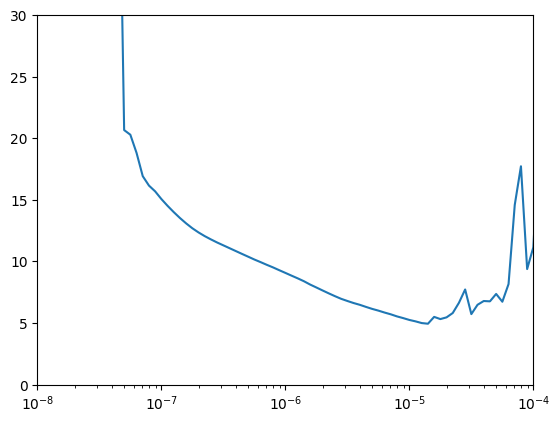

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])
plt.show()

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500, validation_data=val_dataset)

Epoch 1/500
31/31 [==============================] - 5s 44ms/step - loss: 14.7866 - mae: 15.2777 - val_loss: 21.1932 - val_mae: 21.6897
Epoch 2/500
31/31 [==============================] - 0s 12ms/step - loss: 9.0286 - mae: 9.5127 - val_loss: 17.8982 - val_mae: 18.3934
Epoch 3/500
31/31 [==============================] - 0s 12ms/step - loss: 7.5733 - mae: 8.0562 - val_loss: 12.3037 - val_mae: 12.7929
Epoch 4/500
31/31 [==============================] - 0s 12ms/step - loss: 6.7613 - mae: 7.2437 - val_loss: 12.4581 - val_mae: 12.9500
Epoch 5/500
31/31 [==============================] - 0s 12ms/step - loss: 6.2800 - mae: 6.7620 - val_loss: 12.0780 - val_mae: 12.5697
Epoch 6/500
31/31 [==============================] - 0s 12ms/step - loss: 5.9062 - mae: 6.3866 - val_loss: 10.4793 - val_mae: 10.9669
Epoch 7/500
31/31 [==============================] - 0s 12ms/step - loss: 5.5800 - mae: 6.0592 - val_loss: 10.6225 - val_mae: 11.1129
Epoch 8/500
31/31 [==============================] - 1s 13ms

31/31 [==============================] - 0s 12ms/step - loss: 4.2080 - mae: 4.6824 - val_loss: 6.0910 - val_mae: 6.5719
Epoch 63/500
31/31 [==============================] - 0s 12ms/step - loss: 4.2711 - mae: 4.7460 - val_loss: 6.1690 - val_mae: 6.6523
Epoch 64/500
31/31 [==============================] - 0s 13ms/step - loss: 4.2281 - mae: 4.7032 - val_loss: 5.8034 - val_mae: 6.2831
Epoch 65/500
31/31 [==============================] - 0s 12ms/step - loss: 4.2649 - mae: 4.7407 - val_loss: 5.5562 - val_mae: 6.0377
Epoch 66/500
31/31 [==============================] - 0s 12ms/step - loss: 4.2256 - mae: 4.7002 - val_loss: 5.2849 - val_mae: 5.7622
Epoch 67/500
31/31 [==============================] - 0s 12ms/step - loss: 4.4290 - mae: 4.9060 - val_loss: 5.3279 - val_mae: 5.8062
Epoch 68/500
31/31 [==============================] - 0s 12ms/step - loss: 4.3524 - mae: 4.8293 - val_loss: 5.8295 - val_mae: 6.3086
Epoch 69/500
31/31 [==============================] - 1s 13ms/step - loss: 4.1681 

31/31 [==============================] - 0s 12ms/step - loss: 4.1803 - mae: 4.6552 - val_loss: 5.6543 - val_mae: 6.1332
Epoch 124/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0770 - mae: 4.5513 - val_loss: 5.5057 - val_mae: 5.9823
Epoch 125/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0774 - mae: 4.5509 - val_loss: 5.3261 - val_mae: 5.8076
Epoch 126/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0856 - mae: 4.5597 - val_loss: 4.9680 - val_mae: 5.4466
Epoch 127/500
31/31 [==============================] - 0s 12ms/step - loss: 4.1331 - mae: 4.6083 - val_loss: 4.9937 - val_mae: 5.4730
Epoch 128/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0998 - mae: 4.5743 - val_loss: 5.3581 - val_mae: 5.8395
Epoch 129/500
31/31 [==============================] - 0s 13ms/step - loss: 4.0759 - mae: 4.5501 - val_loss: 5.2918 - val_mae: 5.7716
Epoch 130/500
31/31 [==============================] - 0s 12ms/step - loss: 

31/31 [==============================] - 0s 12ms/step - loss: 3.9966 - mae: 4.4696 - val_loss: 4.9779 - val_mae: 5.4585
Epoch 185/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0081 - mae: 4.4815 - val_loss: 4.7788 - val_mae: 5.2550
Epoch 186/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0755 - mae: 4.5485 - val_loss: 4.8301 - val_mae: 5.3074
Epoch 187/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0986 - mae: 4.5726 - val_loss: 5.0201 - val_mae: 5.5017
Epoch 188/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0442 - mae: 4.5173 - val_loss: 5.1417 - val_mae: 5.6240
Epoch 189/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0236 - mae: 4.4974 - val_loss: 5.3287 - val_mae: 5.8073
Epoch 190/500
31/31 [==============================] - 1s 13ms/step - loss: 4.0405 - mae: 4.5144 - val_loss: 5.5211 - val_mae: 5.9995
Epoch 191/500
31/31 [==============================] - 0s 12ms/step - loss: 

Epoch 245/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9776 - mae: 4.4497 - val_loss: 5.2384 - val_mae: 5.7175
Epoch 246/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0373 - mae: 4.5104 - val_loss: 4.7819 - val_mae: 5.2584
Epoch 247/500
31/31 [==============================] - 1s 13ms/step - loss: 3.9954 - mae: 4.4680 - val_loss: 5.1286 - val_mae: 5.6098
Epoch 248/500
31/31 [==============================] - 0s 13ms/step - loss: 3.9619 - mae: 4.4340 - val_loss: 4.9845 - val_mae: 5.4656
Epoch 249/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9650 - mae: 4.4372 - val_loss: 5.4979 - val_mae: 5.9758
Epoch 250/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0104 - mae: 4.4833 - val_loss: 4.8603 - val_mae: 5.3413
Epoch 251/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0297 - mae: 4.5019 - val_loss: 5.3561 - val_mae: 5.8352
Epoch 252/500
31/31 [==============================] - 0s 13ms

31/31 [==============================] - 0s 12ms/step - loss: 3.9306 - mae: 4.4017 - val_loss: 4.7777 - val_mae: 5.2546
Epoch 307/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9655 - mae: 4.4380 - val_loss: 5.2127 - val_mae: 5.6935
Epoch 308/500
31/31 [==============================] - 1s 14ms/step - loss: 3.9277 - mae: 4.3976 - val_loss: 5.1654 - val_mae: 5.6470
Epoch 309/500
31/31 [==============================] - 0s 13ms/step - loss: 3.9631 - mae: 4.4351 - val_loss: 4.7663 - val_mae: 5.2441
Epoch 310/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9601 - mae: 4.4320 - val_loss: 5.3302 - val_mae: 5.8101
Epoch 311/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9367 - mae: 4.4082 - val_loss: 4.7602 - val_mae: 5.2389
Epoch 312/500
31/31 [==============================] - 0s 13ms/step - loss: 4.0152 - mae: 4.4877 - val_loss: 5.4547 - val_mae: 5.9338
Epoch 313/500
31/31 [==============================] - 0s 12ms/step - loss: 

31/31 [==============================] - 0s 12ms/step - loss: 3.9440 - mae: 4.4146 - val_loss: 5.0434 - val_mae: 5.5243
Epoch 368/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9324 - mae: 4.4028 - val_loss: 5.2850 - val_mae: 5.7655
Epoch 369/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9195 - mae: 4.3893 - val_loss: 4.8719 - val_mae: 5.3533
Epoch 370/500
31/31 [==============================] - 0s 12ms/step - loss: 3.8925 - mae: 4.3615 - val_loss: 5.1927 - val_mae: 5.6739
Epoch 371/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9191 - mae: 4.3889 - val_loss: 4.8172 - val_mae: 5.2988
Epoch 372/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9222 - mae: 4.3926 - val_loss: 4.9646 - val_mae: 5.4459
Epoch 373/500
31/31 [==============================] - 1s 13ms/step - loss: 3.9071 - mae: 4.3767 - val_loss: 4.9551 - val_mae: 5.4355
Epoch 374/500
31/31 [==============================] - 0s 12ms/step - loss: 

Epoch 428/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9040 - mae: 4.3737 - val_loss: 5.1972 - val_mae: 5.6783
Epoch 429/500
31/31 [==============================] - 0s 12ms/step - loss: 3.8786 - mae: 4.3478 - val_loss: 4.7466 - val_mae: 5.2244
Epoch 430/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9082 - mae: 4.3773 - val_loss: 4.8374 - val_mae: 5.3181
Epoch 431/500
31/31 [==============================] - 0s 12ms/step - loss: 3.8599 - mae: 4.3283 - val_loss: 4.9855 - val_mae: 5.4664
Epoch 432/500
31/31 [==============================] - 0s 12ms/step - loss: 3.8620 - mae: 4.3306 - val_loss: 5.0387 - val_mae: 5.5197
Epoch 433/500
31/31 [==============================] - 0s 12ms/step - loss: 3.8677 - mae: 4.3365 - val_loss: 5.7411 - val_mae: 6.2220
Epoch 434/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9138 - mae: 4.3827 - val_loss: 4.8255 - val_mae: 5.3075
Epoch 435/500
31/31 [==============================] - 0s 12ms

31/31 [==============================] - 0s 12ms/step - loss: 3.9433 - mae: 4.4148 - val_loss: 5.1249 - val_mae: 5.6061
Epoch 490/500
31/31 [==============================] - 0s 13ms/step - loss: 3.8364 - mae: 4.3050 - val_loss: 5.2209 - val_mae: 5.7024
Epoch 491/500
31/31 [==============================] - 0s 13ms/step - loss: 3.8435 - mae: 4.3119 - val_loss: 4.9807 - val_mae: 5.4613
Epoch 492/500
31/31 [==============================] - 0s 12ms/step - loss: 3.8675 - mae: 4.3374 - val_loss: 4.9677 - val_mae: 5.4486
Epoch 493/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9055 - mae: 4.3758 - val_loss: 4.7870 - val_mae: 5.2654
Epoch 494/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9123 - mae: 4.3836 - val_loss: 4.8468 - val_mae: 5.3297
Epoch 495/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9064 - mae: 4.3767 - val_loss: 5.3655 - val_mae: 5.8451
Epoch 496/500
31/31 [==============================] - 0s 12ms/step - loss: 

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

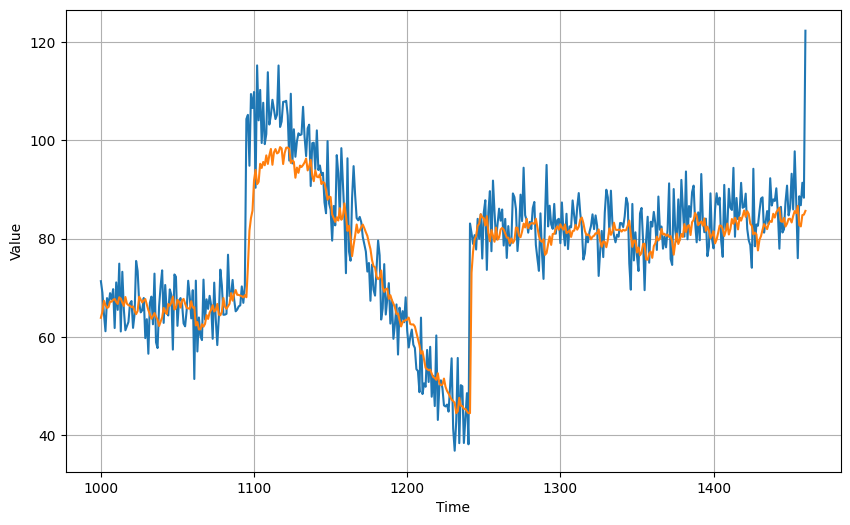

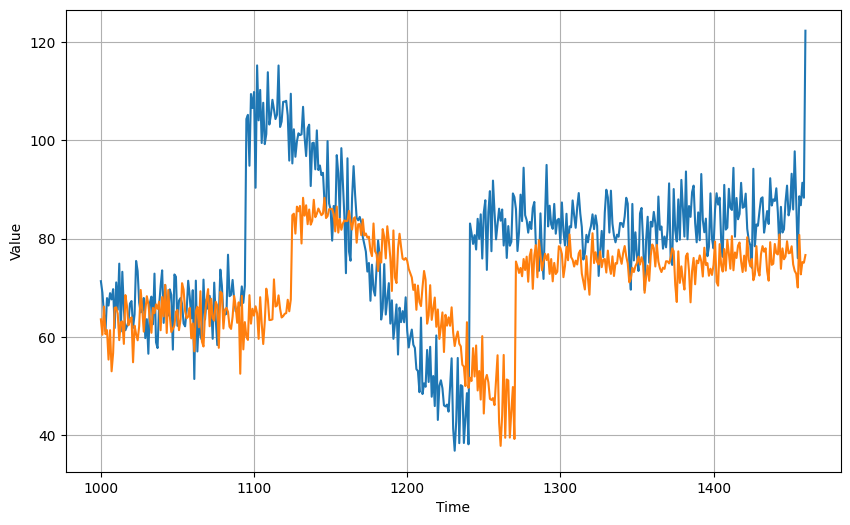

In [13]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.show()

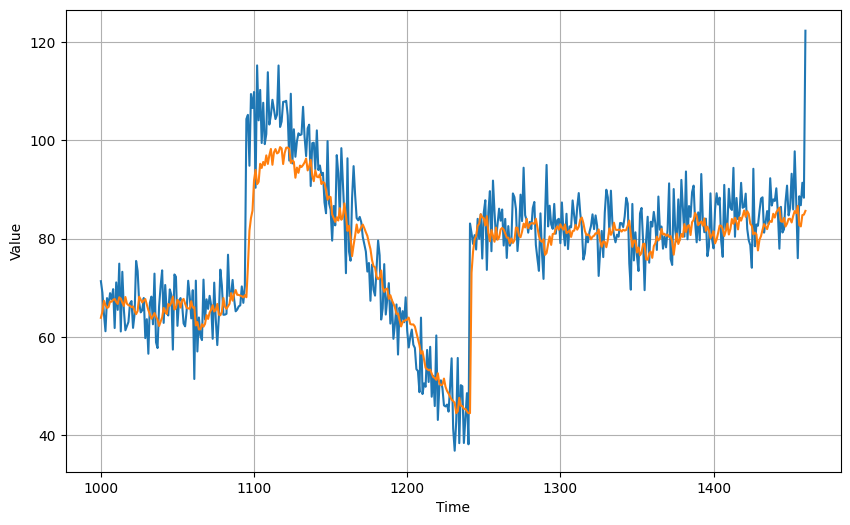

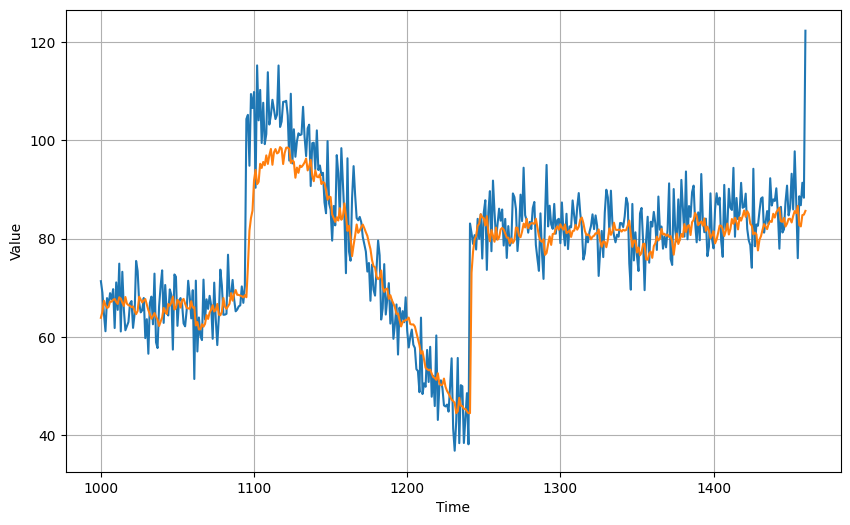

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show()

In [12]:
print(tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

50.718567
5.2316794


In [32]:
rnn_forecast[0:10]

array([63.890587, 65.113556, 67.36574 , 66.49013 , 65.9122  , 66.06045 ,
       67.20977 , 67.163536, 67.54799 , 67.718376], dtype=float32)

In [34]:
np.squeeze(results)[0:10]

array([63.58011 , 60.448456, 66.176674, 60.570168, 61.392246, 55.391754,
       61.3778  , 53.009094, 56.73698 , 65.924164], dtype=float32)

In [28]:
print(tf.keras.metrics.mean_squared_error(x_valid, results[:,0]).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results[:,0]).numpy())

281.25577
12.374481


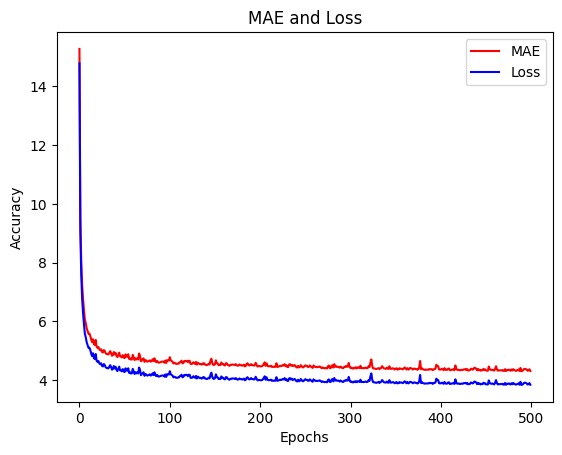

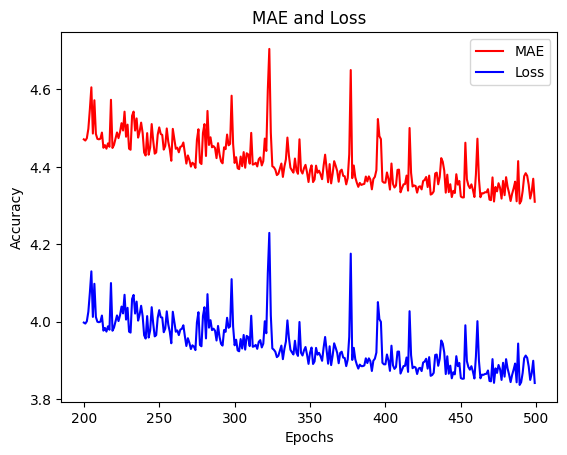

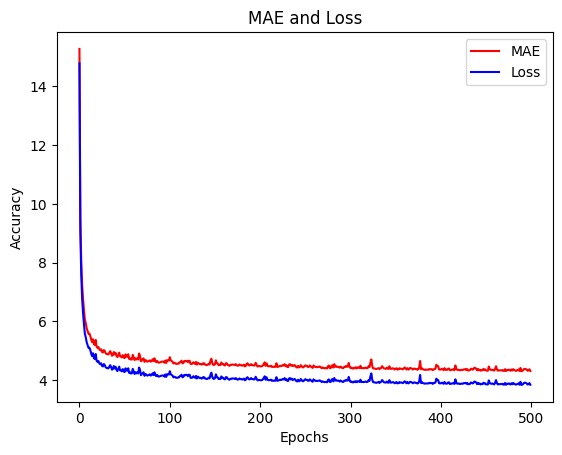

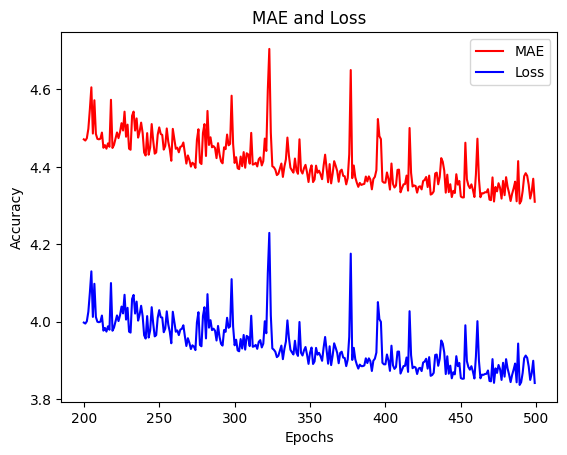

<Figure size 640x480 with 0 Axes>

In [36]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()
plt.show()